In [15]:
import ee
import geemap
from geemap import ml
from sklearn import ensemble
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Inicializa la autenticación y la inicialización de Google Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-facuboladerasgee')

In [3]:
import os

def combine_csv_files(folder_path):
    # Lista para almacenar todos los DataFrames
    df_list = []
    
    # Recorrer todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Leer cada archivo CSV y agregarlo a la lista
            df = pd.read_csv(file_path)
            df_list.append(df)
    
    # Combinar todos los DataFrames en uno solo
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

# Ejemplo de uso
folder_path_2019 = 'C://Users//Facu//Downloads//EE_malawi_2019'
combined_df_2019 = combine_csv_files(folder_path_2019)


folder_path_2020 = 'C://Users//Facu//Downloads//EE_malawi_2020'
combined_df_2020 = combine_csv_files(folder_path_2020)


folder_path_2021 = 'C://Users//Facu//Downloads//EE_malawi_2021'
combined_df_2021 = combine_csv_files(folder_path_2021)

combined_df = pd.concat([combined_df_2019, combined_df_2020, combined_df_2021], ignore_index=True)


In [18]:
import os

def combine_csv_files(folder_path):
    # Lista para almacenar todos los DataFrames
    df_list = []
    
    # Recorrer todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Leer cada archivo CSV y agregarlo a la lista
            df = pd.read_csv(file_path)
            df_list.append(df)
    
    # Combinar todos los DataFrames en uno solo
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

# Ejemplo de uso
folder_path_2019 = 'C://Users//Facu//Downloads//EE_malawi-SP_2019'
combined_df = combine_csv_files(folder_path_2019)

In [19]:
# Calcular la nueva columna 'threshold'
# Calcular la nueva columna 'threshold'
combined_df['threshold'] = (combined_df['agbd_se'] / combined_df['agbd']) * 100
# combined_df = combined_df.loc[combined_df['Slope'] <= 25]

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  10499 non-null  int64  
 1   B11           10499 non-null  float64
 2   B12           10499 non-null  float64
 3   B2            10499 non-null  float64
 4   B3            10499 non-null  float64
 5   B4            10499 non-null  float64
 6   CH            10499 non-null  float64
 7   HH            10499 non-null  float64
 8   HH_HV_div_2   10499 non-null  float64
 9   HH_div_HV     10499 non-null  float64
 10  HH_minus_HV   10499 non-null  float64
 11  HH_plus_HV    10499 non-null  float64
 12  HV            10499 non-null  float64
 13  MNDWI         10499 non-null  float64
 14  NDBI          10499 non-null  float64
 15  NDVI          10499 non-null  float64
 16  RVI           10499 non-null  float64
 17  RVI_palsar    10499 non-null  float64
 18  VH            10499 non-nu

In [20]:
# Filtrar los datos cuyo valor en la columna 'threshold' sea menor que 50
df_filtered = combined_df[combined_df['threshold'] < 50]

# Mostrar las primeras filas del DataFrame filtrado para verificar
df_filtered.describe()

,system:index,B11,B12,B2,B3,B4,CH,HH,HH_HV_div_2,HH_div_HV,...,VV_VH_div_2,VV_div_VH,VV_minus_VH,VV_plus_VH,agbd,agbd_se,elevation,label,slope,threshold
count,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,...,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000,4418.000000
mean,326.677230,2551.326545,1829.610568,439.877026,675.823442,824.842406,6.458805,4424.124943,3251.866569,2.235686,...,-13.572804,0.605951,6.571875,-27.145609,57.255005,5.729736,887.637619,3.511996,11.375703,18.998245
std,302.401798,529.353734,593.281984,120.704198,149.624335,292.988790,7.810511,1368.000690,1020.432773,0.549490,...,1.712607,0.062500,0.672896,3.425214,77.071520,5.582735,385.195987,1.971575,13.006372,12.985308
min,0.000000,614.000000,276.000000,71.500000,102.000000,88.000000,0.000000,1837.000000,1303.500000,1.261735,...,-22.029358,-0.046185,5.016628,-44.058716,6.036954,2.981795,476.000000,1.000000,0.000000,0.784086
25%,100.000000,2262.250000,1422.500000,367.500000,595.000000,626.000000,0.000000,3476.000000,2515.500000,1.876278,...,-14.173532,0.582028,6.122766,-28.347064,11.641123,2.983440,602.000000,1.000000,2.133105,8.286792
50%,229.000000,2605.000000,1869.000000,445.000000,680.500000,854.500000,3.000000,4152.000000,3051.500000,2.135055,...,-13.476002,0.608220,6.465872,-26.952005,23.889874,2.987670,679.500000,5.000000,4.261025,15.663601
75%,472.000000,2910.000000,2225.125000,509.500000,755.000000,1019.375000,10.000000,5067.000000,3780.750000,2.473120,...,-12.765449,0.636260,6.889666,-25.530899,65.477670,3.025380,1222.250000,5.000000,18.062742,27.384629
max,1474.000000,4328.500000,4104.000000,1235.000000,1504.000000,2129.000000,34.000000,13629.000000,9571.500000,6.648804,...,-4.322887,0.778404,11.055733,-8.645775,561.969500,17.173664,1826.000000,6.000000,62.036743,49.550899


In [21]:
def remove_outliers(df, column_name):

    # Calcular la media y la desviación estándar de la columna
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    
    # Calcular el umbral para identificar los outliers
    threshold = 3 * std_dev
    
    # Crear una condición para filtrar los outliers
    condition = (df[column_name] >= (mean - threshold)) & (df[column_name] <= (mean + threshold))
    
    # Crear un nuevo DataFrame con los outliers eliminados
    df_filtered = df[condition]
    
    return df_filtered

# Ejemplo de uso
# Supongamos que tienes un DataFrame llamado df_combined con una columna "agbd"
# df_combined = pd.read_csv("ruta_a_tu_csv.csv")

df_filtered_remove = remove_outliers(df_filtered, "agbd")

# Mostrar las primeras filas del DataFrame filtrado
df_filtered_remove

,system:index,B11,B12,B2,B3,B4,CH,HH,HH_HV_div_2,HH_div_HV,...,VV_div_VH,VV_minus_VH,VV_plus_VH,agbd,agbd_se,elevation,label,slope,.geo,threshold
3,3,2049.0,1429.0,546.0,795.0,856.0,9.0,4849.0,3454.5,2.353883,...,0.613979,6.524582,-27.279684,16.890486,2.982532,626.0,4.0,2.134969,"{""geodesic"":false,""type"":""Point"",""coordinates""...",17.658059
4,4,1998.0,1426.0,523.0,735.0,840.0,9.0,4849.0,3454.5,2.353883,...,0.614849,6.522845,-27.348764,16.890486,2.982532,626.0,4.5,2.134969,"{""geodesic"":false,""type"":""Point"",""coordinates""...",17.658059
5,5,2940.0,2024.0,576.5,810.5,999.0,4.0,4430.0,3130.5,2.419443,...,0.617111,6.456994,-27.270730,7.822563,2.988732,624.0,5.0,4.171833,"{""geodesic"":false,""type"":""Point"",""coordinates""...",38.206557
6,6,2961.0,2117.0,515.0,731.0,938.0,3.0,4924.0,3443.5,2.508405,...,0.609507,6.468358,-26.660845,7.822563,2.988732,626.0,5.0,5.445742,"{""geodesic"":false,""type"":""Point"",""coordinates""...",38.206557
14,14,2937.0,1908.0,578.0,826.0,1304.0,1.0,4702.0,3669.0,1.783763,...,0.561043,6.536305,-23.244740,10.279377,2.986123,653.0,5.0,21.619677,"{""geodesic"":false,""type"":""Point"",""coordinates""...",29.049650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10494,39,2473.0,1523.5,365.5,627.5,677.5,4.0,3983.0,2939.5,2.100738,...,0.616836,6.332750,-26.722290,6.036954,2.991365,977.0,1.0,12.765172,"{""geodesic"":false,""type"":""Point"",""coordinates""...",49.550899
10495,40,2581.5,1477.0,384.5,651.0,755.5,4.0,4024.0,2948.0,2.149573,...,0.621405,6.388723,-27.360920,6.036954,2.991365,980.0,1.0,17.151646,"{""geodesic"":false,""type"":""Point"",""coordinates""...",49.550899
10496,41,2916.0,1827.0,480.0,833.0,1050.0,5.0,4271.0,3166.5,2.071290,...,0.623716,6.253592,-26.985060,33.775635,2.983879,966.0,1.0,15.632306,"{""geodesic"":false,""type"":""Point"",""coordinates""...",8.834413
10497,42,2531.0,1539.0,415.0,743.0,780.0,5.0,4271.0,3122.0,2.164724,...,0.625724,6.424647,-27.906456,33.775635,2.983879,966.0,1.0,15.632306,"{""geodesic"":false,""type"":""Point"",""coordinates""...",8.834413


In [22]:
df_nuevo = df_filtered_remove[df_filtered_remove['agbd'] <= 500]
df_nuevo = df_filtered_remove[df_filtered_remove['slope'] <= 30]
df_nuevo.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3784 entries, 3 to 10498
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  3784 non-null   int64  
 1   B11           3784 non-null   float64
 2   B12           3784 non-null   float64
 3   B2            3784 non-null   float64
 4   B3            3784 non-null   float64
 5   B4            3784 non-null   float64
 6   CH            3784 non-null   float64
 7   HH            3784 non-null   float64
 8   HH_HV_div_2   3784 non-null   float64
 9   HH_div_HV     3784 non-null   float64
 10  HH_minus_HV   3784 non-null   float64
 11  HH_plus_HV    3784 non-null   float64
 12  HV            3784 non-null   float64
 13  MNDWI         3784 non-null   float64
 14  NDBI          3784 non-null   float64
 15  NDVI          3784 non-null   float64
 16  RVI           3784 non-null   float64
 17  RVI_palsar    3784 non-null   float64
 18  VH            3784 non-null   fl

In [20]:
# df_proces = df_filtered_remove[~df_filtered_remove['label'].isin([2, 6])]
# df_proces

In [24]:
def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop)

columns_to_drop = ['threshold', 'agbd_se','.geo','system:index']
df_modified = drop_columns(df_nuevo, columns_to_drop)
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3784 entries, 3 to 10498
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   B11          3784 non-null   float64
 1   B12          3784 non-null   float64
 2   B2           3784 non-null   float64
 3   B3           3784 non-null   float64
 4   B4           3784 non-null   float64
 5   CH           3784 non-null   float64
 6   HH           3784 non-null   float64
 7   HH_HV_div_2  3784 non-null   float64
 8   HH_div_HV    3784 non-null   float64
 9   HH_minus_HV  3784 non-null   float64
 10  HH_plus_HV   3784 non-null   float64
 11  HV           3784 non-null   float64
 12  MNDWI        3784 non-null   float64
 13  NDBI         3784 non-null   float64
 14  NDVI         3784 non-null   float64
 15  RVI          3784 non-null   float64
 16  RVI_palsar   3784 non-null   float64
 17  VH           3784 non-null   float64
 18  VV           3784 non-null   float64
 19  VV_VH_div_

In [25]:
# Obtener los nombres de las columnas excepto 'agbd' y '.geo'
features = [col for col in df_modified.columns if col not in ['agbd','.geo', 'system:index']]

# Mostrar la lista de características
print(features)

['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'HH', 'HH_HV_div_2', 'HH_div_HV', 'HH_minus_HV', 'HH_plus_HV', 'HV', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'RVI_palsar', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'label', 'slope']


In [26]:
feature_names =  ['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'HH', 'HH_HV_div_2', 'HH_div_HV', 'HH_minus_HV', 'HH_plus_HV', 'HV', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'RVI_palsar', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'label', 'slope']

In [27]:
# Separar la variable objetivo 'agbd'
y = df_modified['agbd']

# Separar las variables independientes (todas excepto 'agbd' y '.geo')
X = df_modified.drop(columns=['agbd'])

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3784 entries, 3 to 10498
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   B11          3784 non-null   float64
 1   B12          3784 non-null   float64
 2   B2           3784 non-null   float64
 3   B3           3784 non-null   float64
 4   B4           3784 non-null   float64
 5   CH           3784 non-null   float64
 6   HH           3784 non-null   float64
 7   HH_HV_div_2  3784 non-null   float64
 8   HH_div_HV    3784 non-null   float64
 9   HH_minus_HV  3784 non-null   float64
 10  HH_plus_HV   3784 non-null   float64
 11  HV           3784 non-null   float64
 12  MNDWI        3784 non-null   float64
 13  NDBI         3784 non-null   float64
 14  NDVI         3784 non-null   float64
 15  RVI          3784 non-null   float64
 16  RVI_palsar   3784 non-null   float64
 17  VH           3784 non-null   float64
 18  VV           3784 non-null   float64
 19  VV_VH_div_

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
import numpy as np
rf = RandomForestRegressor(random_state=42)

# Definir el grid de parámetros para buscar
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Entrenar el modelo con los mejores parámetros
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = best_rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')


Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\Facu\anaconda3\envs\Geo\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Root Mean Squared Error: 19.25897104520804
R^2 Score: 0.8086893860025282


In [31]:
import numpy as np
rf = RandomForestRegressor(bootstrap= True, max_depth= 15, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=42) 


rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Root Mean Squared Error: 20.221414477478472
R^2 Score: 0.789090585005477


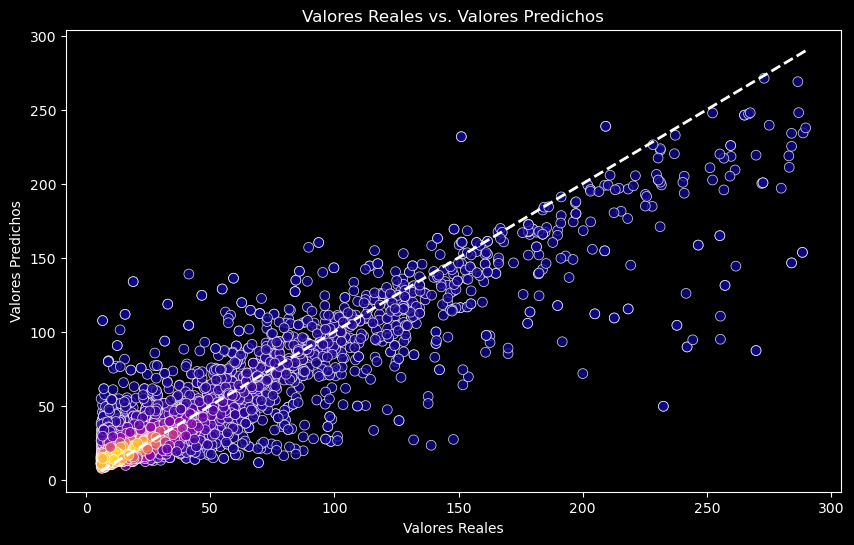

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Calcular la densidad de puntos
xy = np.vstack([y_test, y_pred])
z = gaussian_kde(xy)(xy)

# Crear un gráfico de dispersión con color basado en la densidad de puntos
plt.figure(figsize=(10, 6), facecolor='black')
scatter = plt.scatter(y_test, y_pred, c=z, s=50, cmap='plasma', edgecolor='white', alpha=0.8, linewidth=0.55)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'w--', lw=2)  # Línea de referencia en blanco
plt.xlabel('Valores Reales', color='white')
plt.ylabel('Valores Predichos', color='white')
plt.title('Valores Reales vs. Valores Predichos', color='white')

# Cambiar el color de los ejes y las etiquetas de los ticks
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().xaxis.label.set_color('white')
plt.gca().yaxis.label.set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')

# Cambiar el color del fondo del gráfico
plt.gca().set_facecolor('black')

# Guardar el gráfico
plt.savefig('real_vs_predicho2.png', facecolor='black')

# Mostrar el gráfico
plt.show()


        Feature  Importance
1           B12    0.247717
17        slope    0.175979
16    elevation    0.093500
18        label    0.068050
0           B11    0.056124
14  VV_minus_VH    0.039102
6         MNDWI    0.035426
3            B3    0.033559
10           VH    0.031050
7          NDBI    0.030982
5            B8    0.030365
11           VV    0.025878
2            B2    0.025590
8          NDVI    0.025395
4            B4    0.022334
13    VV_div_VH    0.018028
9           RVI    0.016106
12  VV_VH_div_2    0.012610
15   VV_plus_VH    0.012207


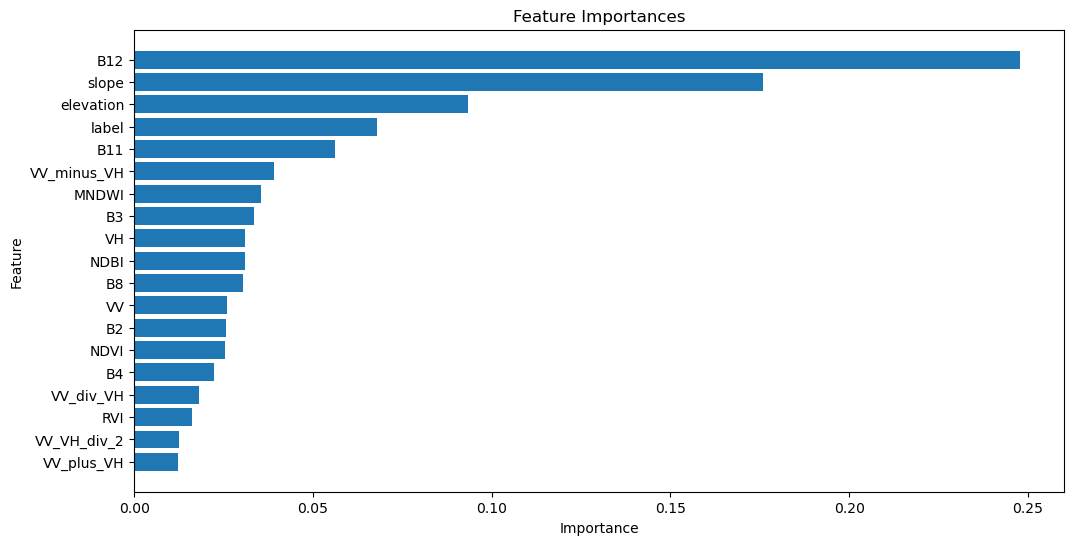

In [167]:
import matplotlib.pyplot as plt
# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Crear un DataFrame para organizar las importancias de las características
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar el DataFrame por importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Mostrar las importancias de las características
print(feature_importances_df)

# Graficar las importancias de las características
plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [32]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf, feature_names,output_mode='regression')
# print the first tree to see the result
# print(trees[0])

In [20]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)
# ee_classifier.getInfo()

In [34]:
user_id = 'users/facuboladerasgee'
# specify asset id where to save trees
# be sure to change  to your ee user name
asset_id = user_id + "/Rf_Malawi"
asset_id
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

In [14]:
def export_model_in_parts(model, feature_names, user_id, base_asset_id, part_size=10):
    trees = ml.rf_to_strings(model, feature_names, output_mode='regression')
    total_trees = len(trees)
    
    # Dividir los árboles en partes
    for i in range(0, total_trees, part_size):
        part_trees = trees[i:i+part_size]
        part_asset_id = f"{base_asset_id}_part_{i//part_size}"
        
        # Exportar la parte
        ml.export_trees_to_fc(part_trees, part_asset_id)
        print(f"Parte {i//part_size} exportada a {part_asset_id}")

# Ejemplo de uso:
user_id = 'users/facuboladerasgee'
base_asset_id = f"{user_id}/Rf_MalawiCH_Join"
export_model_in_parts(rf, feature_names, user_id, base_asset_id)

Parte 0 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_0
Parte 1 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_1
Parte 2 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_2
Parte 3 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_3
Parte 4 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_4
Parte 5 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_5
Parte 6 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_6
Parte 7 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_7
Parte 8 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_8
Parte 9 exportada a users/facuboladerasgee/Rf_MalawiCH_Join_part_9


In [ ]:
# # Exporta la imagen a Google Cloud Storage
# task = ee.batch.Export.image.toCloudStorage(
#     image=image,
#     description='Sentinel-2_export',
#     bucket='your_bucket_name',  # Reemplaza con el nombre de tu bucket
#     fileNamePrefix='sentinel-2_export',
#     scale=30,
#     region=region,
#     maxPixels=1e13  # Ajusta el límite de píxeles si es necesario
# )

# # Inicia la tarea de exportación
# task.start()

# print('Export task started. Check the GCS bucket for the exported files.')

# Prueba Modelo

In [21]:
# Definir la región de interés
roi = ee.FeatureCollection('projects/facub-gee/assets/Nepal')
# Centrar el mapa en la región de interés
Map = geemap.Map(center=[0, 0], zoom=2)
# Añadir Google Satellite como mapa base
Map.add_basemap('SATELLITE')
Map.centerObject(roi)


# Parámetros de visualización para imágenes multiespectrales en falso color nir-swir1-swir2
visFalseColor = {
    'min': 0,
    'max': 3000,
    'bands': ['B8', 'B11', 'B12']
}

# Parámetros de visualización para la biomasa
visBiomass = {'min': 0, 'max': 100, 'palette': ['lightyellow', 'lightgreen', 'green', 'darkgreen']}

# Parámetros de visualización para Sentinel-1
visParamsS1 = {
    'min': -25,
    'max': 0,
    'bands': ['VV', 'VH']
}

# Definir el año de análisis
year = 2020

# Definir la fecha de inicio y fin para filtrar la colección
start = f'{year}-01-01'
end = f'{year}-12-31'

# Filtrar la colección Sentinel-2
s2Col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(roi) \
    .filterDate(start, end)

# Filtrar la colección Sentinel-2 cloud score
cloudCol = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') \
    .filterBounds(roi) \
    .filterDate(start, end)

# Combinar la colección, máscara de nubes y hacer un composite mediano
def mask_clouds(image):
    cloud_score = ee.Image(cloudCol.filterMetadata('system:index', 'equals', image.get('system:index')).first())
    mask = cloud_score.select('probability').lt(10)
    return image.updateMask(mask)

image = s2Col.map(mask_clouds).median().toFloat().clip(roi)

# Calcular NDVI y MNDWI
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
# Calcular NDBI
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')

# Añadir bandas NDVI, MNDWI y NDBI a la imagen
image = image.addBands(ndvi).addBands(mndwi).addBands(ndbi)

# Integrar la banda "label" de Dynamic World
dwCol = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
    .filterBounds(roi) \
    .filterDate(start, end)

dwLabel = dwCol.select('label').median().clip(roi)


# Añadir la banda "label" de Dynamic World a la imagen
image = image.addBands(dwLabel.rename('label'))

# Cargar la imagen de altura de dosel
canopy_height = ee.Image("users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1")

# Recortar la imagen de altura de dosel a la ROI
canopy_height = canopy_height.clip(roi)

# Agregar la banda de altura de dosel a la imagen de datos de biomasa de GEDI
image = image.addBands(canopy_height.rename('CH'))


# Definir las bandas para predecir la biomasa
bands = ['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']


# Función de preprocesamiento
def preprocess(image):
    # Aplicar corrección de ángulo de incidencia
    # image = apply_incidence_angle_correction(image)
    # Filtrado de Speckle
    speckle_filtered = image.focal_median(kernelType='circle', radius=50, units='meters')

    return speckle_filtered
# Definir la función de máscara de borde
def mask_edge(image):
    edge = image.lt(-30.0)
    masked_image = image.mask().And(edge.Not())
    return image.updateMask(masked_image)

# Filtrar y procesar la colección Sentinel-1 para VV
img_vv = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(roi)
    .filterDate(start, end)
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .select('VV')

    .map(mask_edge)
    .map(preprocess)
)

# Filtrar y procesar la colección Sentinel-1 para VH
img_vh = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(roi)
    .filterDate(start, end)
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .select('VH')

    .map(mask_edge)
    .map(preprocess)
)


# Promedio de imágenes VV y VH
s1_vv = img_vv.median().rename('VV')
s1_vh = img_vh.median().rename('VH')



# Calcular el índice RVI
rvi = s1_vh.divide(s1_vv.add(s1_vh)).multiply(4).rename('RVI')
vv_plus_vh = s1_vv.add(s1_vh).rename('VV_plus_VH')
vv_minus_vh = s1_vv.subtract(s1_vh).rename('VV_minus_VH')
vv_div_vh = s1_vv.divide(s1_vh).rename('VV_div_VH')
vv_vh_div_2 = s1_vv.add(s1_vh).divide(2).rename('VV_VH_div_2')

# Combinar las bandas VV, VH y RVI en una sola imagen
s1_combined = ee.Image.cat([s1_vv, s1_vh, vv_plus_vh, vv_minus_vh, vv_div_vh, vv_vh_div_2, rvi]).clip(roi)

# Añadir las bandas VV, VH, RVI y álgebra de bandas a la imagen
image = image.addBands(s1_combined)

# Añadir SRTM DEM y pendiente
dem = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
slope = ee.Terrain.slope(dem).rename('slope').clip(roi)

# Añadir las bandas DEM y pendiente a la imagen
image = image.addBands(dem.rename('elevation'))
image = image.addBands(slope)

# Seleccionar solo las bandas especificadas
image = image.select(bands)


In [22]:
# classify the image again but with the classifier from the persisted trees
classified = image.select(feature_names).classify(ee_classifier)


# Centrar el mapa en la región de interés
Map = geemap.Map(center=[0, 0], zoom=2)
Map.centerObject(roi)

visPredictedBiomass = {
    'min': 0,
    'max': 60,
    'palette': ['lightyellow', 'lightgreen', 'green', 'darkgreen']
}

Map = geemap.Map(zoom=11)
Map.add_basemap('SATELLITE')
Map.centerObject(roi)

Map.addLayer(
    classified,
    visPredictedBiomass,
    "classification",)
Map.add_colorbar(visPredictedBiomass, label="Predicted Biomass")
Map

EEException: Request payload size exceeds the limit: 10485760 bytes.